# Cluster points and explore boundary *blurriness* with A-DBSCAN 

In this example, we will illustrate how to use A-DBSCAN ([Arribas-Bel et al., 2019](https://www.sciencedirect.com/science/article/abs/pii/S0094119019300944)) with a sample of AirBnb properties in Berlin. A-DBSCAN will allow us do two things:

- Identify clusters of high density of AirBnb properties and delineate their boundaries
- Explore the stability of such boundaries


In [1]:
import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas
from libpysal.cg.alpha_shapes import alpha_shape_auto
from shapely import Polygon

from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls

## Data

We will be using the Berlin extract from [Inside Airbnb](http://insideairbnb.com/). This is the same dataset used in the [Scipy 2018 tutorial on Geospatial data analysis with Python](https://github.com/geopandas/scipy2018-geospatial-data).

In [2]:
tab = pandas.read_csv("data/berlin-listings.csv")
tab.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,0,17260587,https://www.airbnb.com/rooms/17260587,20170507222235,2017-05-08,Kunterbuntes Zimmer mit eigenem Bad für jedermann,"Meine Unterkunft ist gut für paare, alleinreis...",NaN,"Meine Unterkunft ist gut für paare, alleinreis...",none,...,10.0,f,NaN,NaN,t,flexible,f,f,3,2.00
1,1,17227881,https://www.airbnb.com/rooms/17227881,20170507222235,2017-05-08,Modernes Zimmer in Berlin Pankow,Es ist ein schönes gepflegtes und modernes Zim...,Das Haus befindet sich direkt vor eine Tram Ha...,Es ist ein schönes gepflegtes und modernes Zim...,none,...,10.0,f,NaN,NaN,t,flexible,f,f,1,1.29


The original dataset includes more than 20,000 observations:

In [3]:
tab.shape

(20053, 96)

To make the illustration run a bit speedier on any hardware, let us pick a random sample of 10% of the set; that is we'll pick 2,000 properties at random:

In [4]:
tab = tab.sample(n=2000, random_state=1234)

For convenience, we convert into a `GeoDataFrame` where the geometries are built from the lon/lat columns in the original table:

In [5]:
db_ll = geopandas.GeoDataFrame(
    tab,
    geometry=geopandas.points_from_xy(tab.longitude, tab.latitude),
    crs=4326,
)

Because we are going to run an algorithm that relies on distances, we need to be able to calculate such distances in a projected plane. Instead of the original lon/lat coordinates, we use the [`ETRS89`](http://epsg.io/5243) projection, designed for Germany and expressed in metres:

In [6]:
db = db_ll.to_crs(epsg=5243)

*Voila!* We can now visualise our dataset:

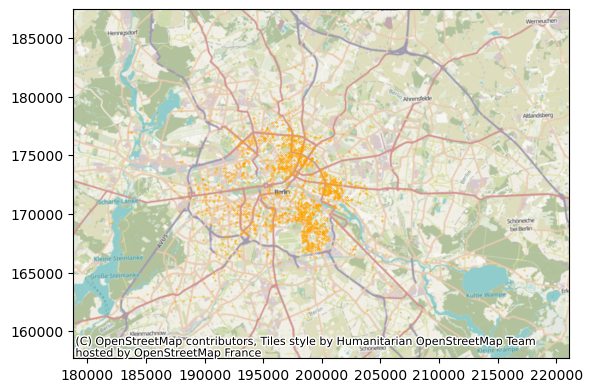

In [7]:
ax = db.plot(markersize=0.1, color="orange")
cx.add_basemap(ax, crs=db.crs.to_string());

And before we get going, we will also pull out the projected coordinates into separate columns:

In [8]:
db["X"] = db.geometry.x
db["Y"] = db.geometry.y

## Identify clusters of AirBnb

A-DBSCAN, similar to the original DBSCAN algorithm, requires two parameters before it can be run:

1. `eps`: maximum distance to look for neighbors from each location
1. `min_samples`: minimum number of neighboring points required for a point to be considered part of a cluster

For this example, we will pick a 1% of the overall sample size for the `min_samples` parameter:

In [9]:
db.shape[0] * 0.01

20.0

We will use a maximum radious of 500m for the `eps` parameter. This implicitly implies we are looking at a density of at least about 25 properties per Sq. $Km^2$ ($dens = \frac{20}{\pi \, \times \, 0.5^2}$).

Once we know the parameters we'll use, we can go ahead and run A-DBSCAN:

In [10]:
%%time
# Get clusters
adbs = ADBSCAN(500, 20, pct_exact=0.5, reps=10, keep_solus=True)
np.random.seed(1234)
adbs.fit(db)

CPU times: user 72.6 ms, sys: 1.54 ms, total: 74.1 ms
Wall time: 74.7 ms


,eps,500
,min_samples,20
,algorithm,'auto'
,n_jobs,1
,pct_exact,0.5
,reps,10
,keep_solus,True
,pct_thr,0.9


Once `fit()`, we can extract the labels in a similar way that we would from `scikit-learn`, and then we can plot on a map:

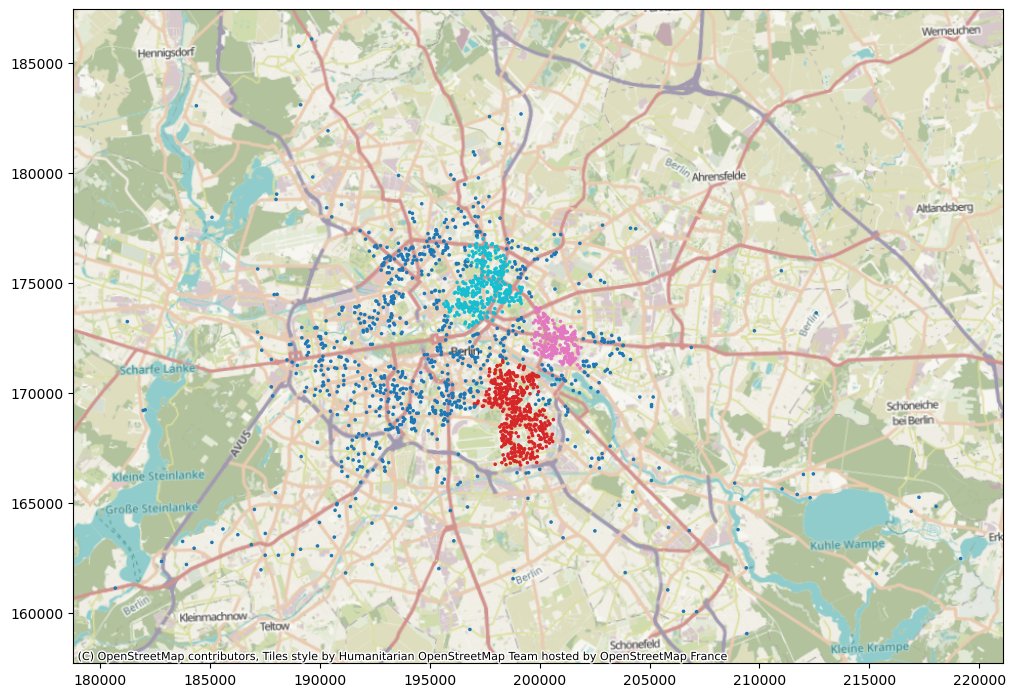

In [11]:
ax = db.assign(lbls=adbs.votes["lbls"]).plot(
    column="lbls", categorical=True, markersize=2.5, figsize=(12, 12)
)
cx.add_basemap(ax, crs=db.crs.to_string());

This only displays each property colored based on its label assigned. Beyond this, we can also create polygons that represent a tight boundary around all the points in a given cluster. To do this, we use the $\alpha$-shapes algorithm through the helper function `get_cluster_boundary`:

In [12]:
%%time
polys = get_cluster_boundary(adbs.votes["lbls"], db, crs=db.crs)

CPU times: user 1.71 s, sys: 94.8 ms, total: 1.8 s
Wall time: 1.85 s


These polygons can also be plotted as any other `GeoSeries` object:

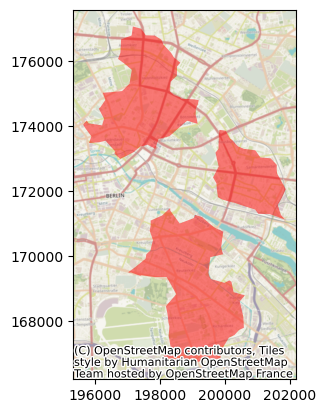

In [13]:
ax = polys.plot(alpha=0.5, color="red")
cx.add_basemap(ax, crs=polys.crs.to_string());

And, just for fun, we can create more zoomed-in views, dimming out areas outside each cluster:

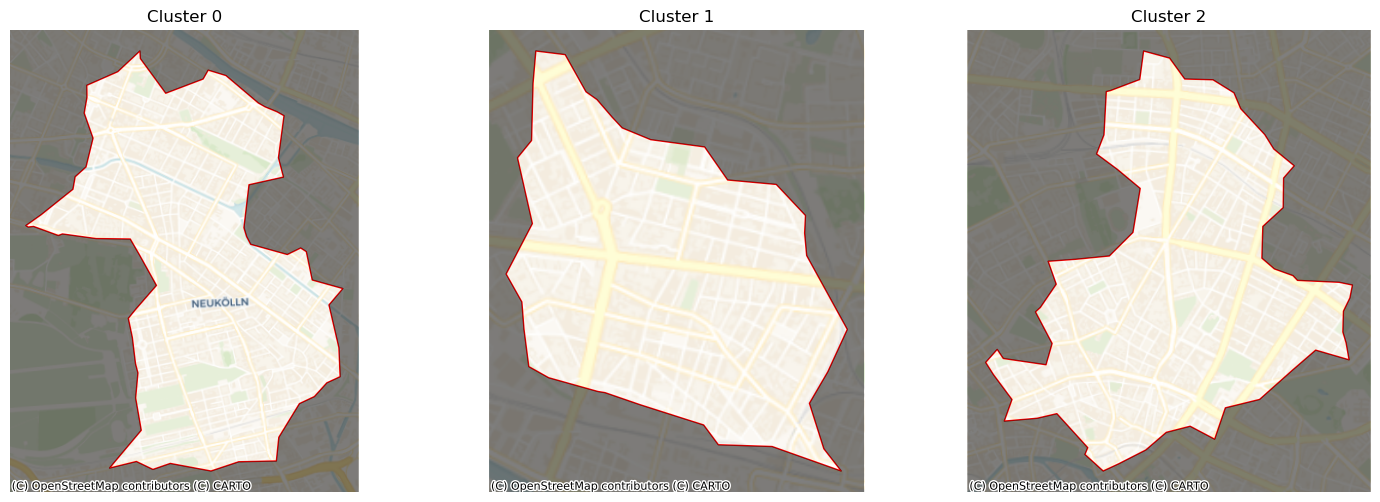

In [51]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axs):
    # Plot the boundary of the cluster found
    ax = polys.iloc[[i]].plot(ax=ax, edgecolor="red", facecolor="none")
    # Add basemap
    cx.add_basemap(
        ax, crs=polys.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=13
    )
    # Extra to dim non-cluster areas
    (minx, maxx), (miny, maxy) = ax.get_xlim(), ax.get_ylim()
    bb = Polygon([(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)])
    geopandas.GeoSeries([bb.difference(polys.iloc[i])], crs=polys.crs).plot(
        ax=ax, color="k", alpha=0.5
    )
    ax.set_axis_off()
    ax.set_title(f"Cluster {polys.iloc[[i]].index[0]}")
plt.show()

## Explore boundary *blurriness*

One of the key benefits of A-DBSCAN is that, because it relies on an ensemble approach that generates several candidate solutions, it allows us to explore to what extent boundaries are stable and clearcut or blurrier. To do this, we need to extract from the `ADBSCAN` object each candidate solution and turn them into boundary lines (this may take a little bit to run):

In [38]:
# %%time
solus_rl = remap_lbls(adbs.solus, db, n_jobs=-1)
lines = []
for rep in solus_rl:
    line = get_cluster_boundary(solus_rl[rep], db, crs=db.crs, n_jobs=-1)
    line = line.boundary
    line = (
        line.reset_index()
        .rename(columns={0: "geometry", "index": "cluster_id"})
        .assign(rep=rep)
    )
    lines.append(line)
lines = pandas.concat(lines)
lines = geopandas.GeoDataFrame(lines, geometry="geometry", crs=db.crs)

AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

Here is a first look at all the solutions drawn up from the simulation:

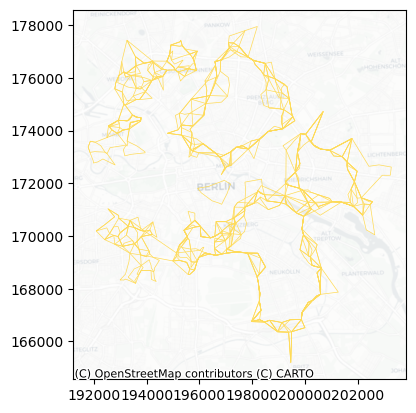

In [53]:
ax = lines.plot(color="#FFDB58", linewidth=0.5)
cx.add_basemap(
    ax, alpha=0.5, source=cx.providers.CartoDB.Positron, crs=lines.crs.to_string()
)

Having every single candidate boundary stored and labelled into a table, it allows us to make several queries. For example, here are all the solutions generated in the first replication:

<Axes: >

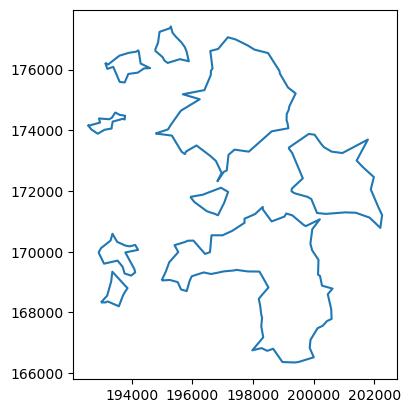

In [54]:
lines.query("rep == 'rep-00'").plot()

And here we have all the candidate solutions for cluster label No. 2:

<Axes: >

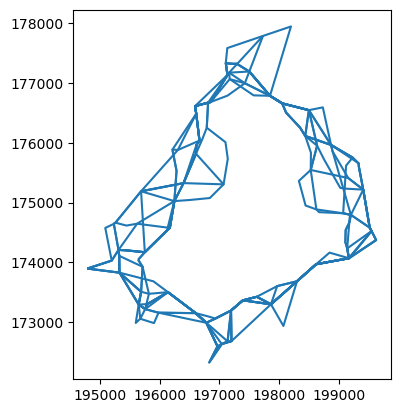

In [55]:
lines.query("cluster_id == '2'").plot()

Finally, we can take this idea into an interactive context by building widgets that allow us to brush through replications:

In [57]:
from ipywidgets import IntSlider, interact

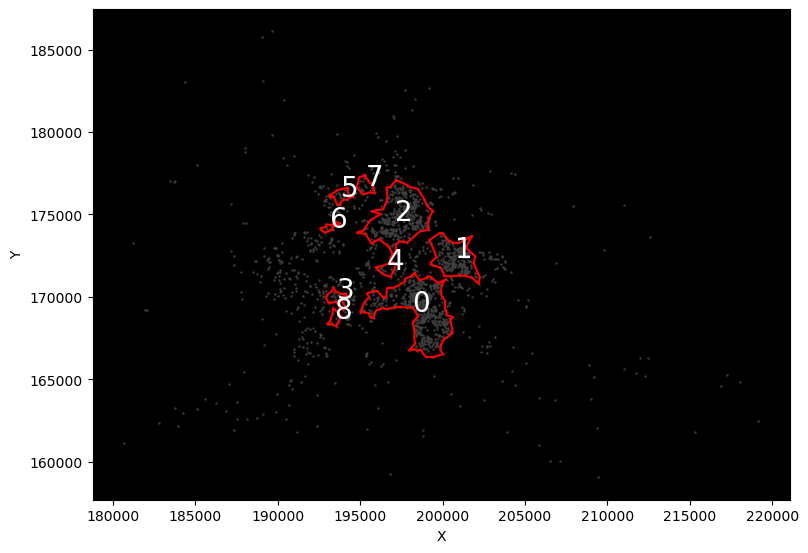

interactive(children=(IntSlider(value=0, description='rep', max=9), Output()), _dom_classes=('widget-interact'…

In [58]:
def plot_rep(rep):
    f, ax = plt.subplots(1, figsize=(9, 9))
    ax.set_facecolor("k")
    # Background points
    db[["X", "Y"]].plot.scatter("X", "Y", ax=ax, color="0.25", s=0.5)
    # Boundaries
    cs = lines.query(f"rep == 'rep-{str(rep).zfill(2)}'")
    cs.plot(ax=ax, color="red")
    # Cluster IDs
    for s, row in cs.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, s, size=20, c="w")
    return None


reps = range(len(lines["rep"].unique()))
slider = IntSlider(min=min(reps), max=max(reps), step=1)
interact(plot_rep, rep=slider);

Or to pull out all solutions for a given cluster IDs:

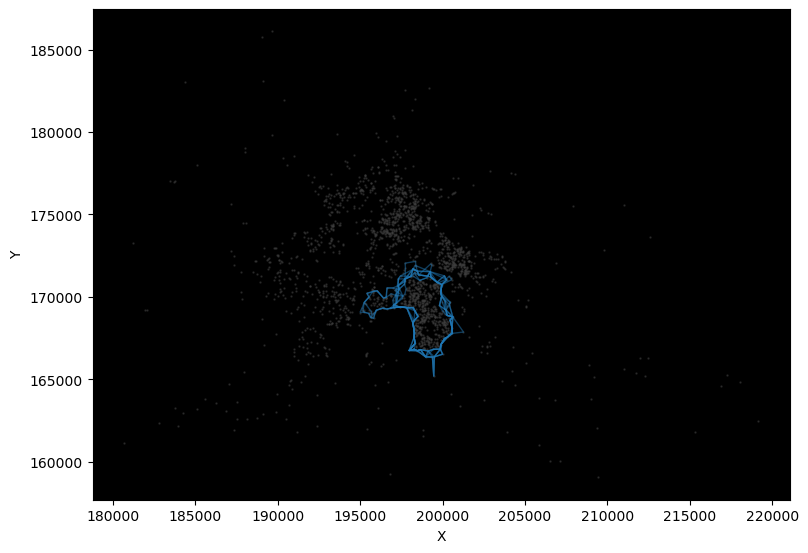

interactive(children=(Dropdown(description='cluster_id', options=('0', '1', '2', '3', '4', '5', '6', '7', '8')…

In [59]:
def plot_cluster(cluster_id):
    f, ax = plt.subplots(1, figsize=(9, 9))
    ax.set_facecolor("k")
    # Background points
    db[["X", "Y"]].plot.scatter("X", "Y", ax=ax, color="0.25", s=0.5, alpha=0.5)
    # Boundaries
    lines.query(f"cluster_id == '{cluster_id}'").plot(ax=ax, linewidth=1, alpha=0.5)
    return None


interact(plot_cluster, cluster_id=lines["cluster_id"].unique());